### Step 1: Setup and imports

In [1]:
# If you do not have pytorch installed please do so.
# I'm using Google Colab and it already has PyTorch installed.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights

import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os


print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.9.0+cu126
CUDA available: True
Device: NVIDIA A100-SXM4-80GB


### Step 2: Download the Ants & Bees dataset

In [2]:
import urllib.request
import zipfile

# Download dataset
url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
filename = "hymenoptera_data.zip"

if not os.path.exists("hymenoptera_data"):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, filename)
    
    print("Extracting...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(".")
    
    os.remove(filename)
    print("Done!")
else:
    print("Dataset already exists!")

# Check the structure
print("\nDataset structure:")
for split in ['train', 'val']:
    for cls in ['ants', 'bees']:
        path = f"hymenoptera_data/{split}/{cls}"
        num_images = len(os.listdir(path))
        print(f"  {split}/{cls}: {num_images} images")

Extracting...
Done!

Dataset structure:
  train/ants: 124 images
  train/bees: 121 images
  val/ants: 70 images
  val/bees: 83 images


### Step 3: Define Data transforms

In [4]:
# ImageNet normalization (required for pretrained models)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),      # Random crop and resize to 224x224
        transforms.RandomHorizontalFlip(),       # Flip horizontally (50% chance)
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),                  # Resize to 256
        transforms.CenterCrop(224),              # Center crop to 224x224
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
}

### Step 4: Load dataset using ImageFolder

In [5]:
# ImageFolder automatically creates a dataset from a folder structure where each subfolder is a class.
data_dir = 'hymenoptera_data'

# Create datasets
image_datasets = {
    split: datasets.ImageFolder(
        os.path.join(data_dir, split),
        data_transforms[split]
    )
    for split in ['train', 'val']
}

In [6]:
# Create dataloaders
batch_size = 4  # Small dataset, so small batch size

dataloaders = {
    split: DataLoader(
        image_datasets[split],
        batch_size=batch_size,
        shuffle=(split == 'train'),  # Shuffle only training data
        num_workers=2
    )
    for split in ['train', 'val']
}

In [7]:
# Dataset info
dataset_sizes = {split: len(image_datasets[split]) for split in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")
print(f"Training samples: {dataset_sizes['train']}")
print(f"Validation samples: {dataset_sizes['val']}")

Classes: ['ants', 'bees']
Training samples: 244
Validation samples: 153


### Step 5: Visualize some training images

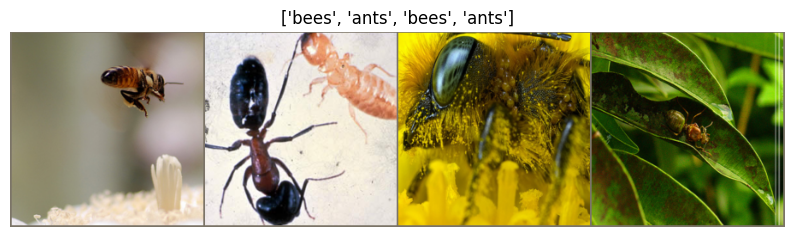

In [11]:
def imshow(inp, title=None):
    """Display image from tensor."""
    # Denormalize
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(imagenet_mean)
    std = np.array(imagenet_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid 
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(10, 4))
imshow(out, title=[class_names[x] for x in classes])
plt.show()

### Step 6: Load a pretrained ResNet-18 and apply modify

In [13]:
# Load pretrained ResNet-18
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check original FC layer
print(f"Original FC layer: {model.fc}")
# Output: Linear(in_features=512, out_features=1000)

# Replace FC layer for binary classification (2 classes: ants, bees)
num_features = model.fc.in_features  # 512
model.fc = nn.Linear(num_features, 2)

print(f"New FC layer: {model.fc}")
# Output: Linear(in_features=512, out_features=2)

# Move to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


Using device: cuda
Original FC layer: Linear(in_features=512, out_features=1000, bias=True)
New FC layer: Linear(in_features=512, out_features=2, bias=True)

Total parameters: 11,177,538
Trainable parameters: 11,177,538


### Step 7: Define Loss, Optimizer, and Scheduler

In [14]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - SGD with momentum (as in the official tutorial)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler - decay by 0.1 every 7 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Step 8: Training function

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):

    since = time.time()
    
    # Track best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Track history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)
        
        # Each epoch has training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
            else:
                model.eval()   # Evaluation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero gradients
                optimizer.zero_grad()
                
                # Forward pass
                # Track gradients only in train phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only in train phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # Step scheduler after training phase
            if phase == 'train':
                scheduler.step()
            
            # Calculate epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase:5s} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Record history
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

### Step 9: Train and evaluate the model

In [ ]:
num_epochs = 25 

model, history = train_model(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=num_epochs # 25 epochs by default 
)

Epoch 1/25
------------------------------
train Loss: 0.2075 Acc: 0.9139
val   Loss: 0.2419 Acc: 0.9281

Epoch 2/25
------------------------------
train Loss: 0.3119 Acc: 0.8484
val   Loss: 0.2574 Acc: 0.9346

Epoch 3/25
------------------------------
train Loss: 0.2396 Acc: 0.9016
val   Loss: 0.2510 Acc: 0.9281

Epoch 4/25
------------------------------
train Loss: 0.2602 Acc: 0.8934
val   Loss: 0.2448 Acc: 0.9281

Epoch 5/25
------------------------------
train Loss: 0.2925 Acc: 0.8607
val   Loss: 0.2507 Acc: 0.9281

Epoch 6/25
------------------------------
train Loss: 0.2138 Acc: 0.9016
val   Loss: 0.2455 Acc: 0.9281

Epoch 7/25
------------------------------
train Loss: 0.3130 Acc: 0.8648
val   Loss: 0.2409 Acc: 0.9346

Epoch 8/25
------------------------------
train Loss: 0.2515 Acc: 0.9098
val   Loss: 0.2460 Acc: 0.9346

Epoch 9/25
------------------------------
train Loss: 0.2749 Acc: 0.8689
val   Loss: 0.2753 Acc: 0.9085

Epoch 10/25
------------------------------
train Loss: 

### Step 10: Plot training history

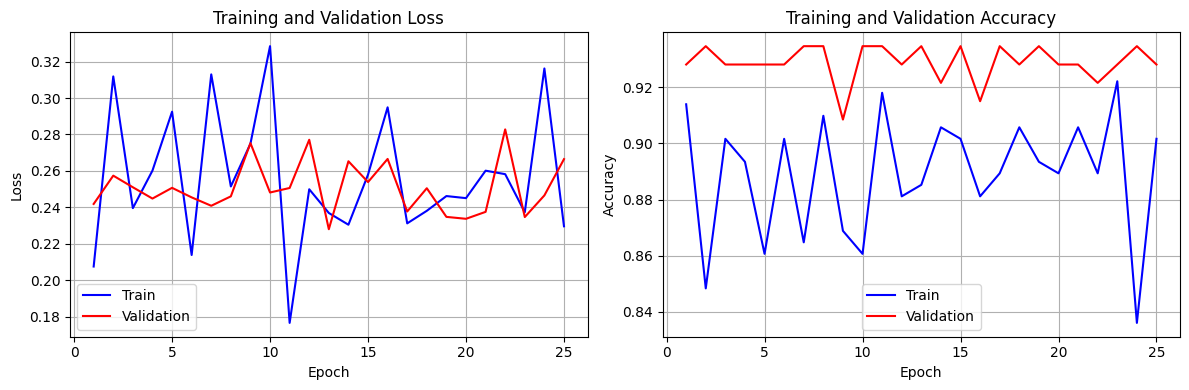

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs, history['train_loss'], 'b-', label='Train')
axes[0].plot(epochs, history['val_loss'], 'r-', label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(epochs, history['train_acc'], 'b-', label='Train')
axes[1].plot(epochs, history['val_acc'], 'r-', label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Step 11: Visualize predictions

In [31]:
def visualize_model(model, num_images=6):
    # Save current training state to restore later
    was_training = model.training
    
    # Set model to evaluation mode
    model.eval()
    
    # Counter for images displayed
    images_so_far = 0
    
    # Create a new figure
    fig = plt.figure()

    # Disable gradient computation for inference
    with torch.no_grad():
        
        # Loop through validation data batches
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            
            # Move data to device (GPU/CPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass to get predictions
            outputs = model(inputs)
            
            # Get predicted class index (ignore the max values, keep indices)
            _, preds = torch.max(outputs, 1)

            # Loop through each image in the batch
            for j in range(inputs.size()[0]):
                images_so_far += 1
                
                # Create subplot (rows = num_images//2, cols = 2)
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                
                # Display image using helper function
                imshow(inputs.cpu().data[j])

                # Stop when we've shown enough images
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        
        # Restore original training state
        model.train(mode=was_training)

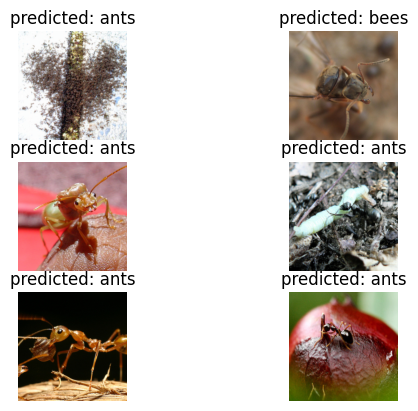

In [ ]:
visualize_model(model)

### Step 12: Save the model

In [33]:
# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
}, 'resnet18_ants_bees.pth')
print("Model saved!")

Model saved!


In [ ]:
# Load model
def load_model(filepath):
    checkpoint = torch.load(filepath, map_location=device)
    
    model = resnet18(weights=None)
    model.fc = nn.Linear(512, 2)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    return model, checkpoint['class_names']

#loaded_model, loaded_classes = load_model('resnet18_ants_bees.pth')
# print(f"Model loaded! Classes: {class_names}")

Model loaded! Classes: ['ants', 'bees']


### Alternative - Feature Extraction
Freeze all layers except the final FC layer.  
Note: In case you would like to try out this code, simply copy/paste it in cell at step 6, uncomment and run it.

In [ ]:
# Create a new model for feature extraction
#model_fe = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze all parameters
#for param in model_fe.parameters():
#    param.requires_grad = False

# Replace and unfreeze FC layer (new layers have requires_grad=True by default)
#model_fe.fc = nn.Linear(model_fe.fc.in_features, 2)

#model_fe = model_fe.to(device)

# Only optimize the FC layer parameters
#optimizer_fe = optim.SGD(model_fe.fc.parameters(), lr=0.001, momentum=0.9)
#scheduler_fe = optim.lr_scheduler.StepLR(optimizer_fe, step_size=7, gamma=0.1)

# Count trainable parameters
#trainable = sum(p.numel() for p in model_fe.parameters() if p.requires_grad)
#print(f"Trainable parameters: {trainable:,}")  # Only ~1,026 parameters!

# Train (much faster!)
# model_fe, history_fe = train_model(model_fe, criterion, optimizer_fe, scheduler_fe, num_epochs=15)